In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Ensemble methods
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import pydot

In [2]:
# Load json dataset into pandas
data = pd.read_json('train.json')
test = pd.read_json('test.json')
#print data.dtypes
print data.info()
#print test.info()
#print data.describe()
#print data['post_was_edited'].value_counts()
#print np.unique(data['requester_received_pizza'])
print 1 - data['requester_received_pizza'].mean() # Baseline is 24% received pizza
#print data['giver_username_if_known'].value_counts() # .value_counts is useful
#print data['request_text'].value_counts() # pretty everything except for 'Please and thank you!' is 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 32 columns):
giver_username_if_known                                 4040 non-null object
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_id                                              4040 non-null object
request_number_of_comments_at_retrieval                 4040 non-null int64
request_text                                            4040 non-null object
request_text_edit_aware                                 4040 non-null object
request_title                                           4040 non-null object
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_reque

In [3]:
# Clean the data and remove labels - put in own dataframe
data['requester_received_pizza'] = data['requester_received_pizza'].map({False: 0, True:1}).astype(int)
# post_was_edited has bad data - includes unix timestamps. need to convert to 1s
data['post_was_edited'] = data['post_was_edited'].map(lambda x: 1 if x > 0 else 0)
labels = data['requester_received_pizza']
del data['requester_received_pizza']

In [4]:
# Remove train features not in test data
def remove_train_features():
    data_cols = set(data.columns.values)
    test_cols = set(test.columns.values)
    trim_data_cols = data_cols.intersection(test_cols)
    return list(trim_data_cols)

trim_data_cols = remove_train_features()
data = data[trim_data_cols]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 17 columns):
request_title                                         4040 non-null object
unix_timestamp_of_request                             4040 non-null int64
giver_username_if_known                               4040 non-null object
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_subreddits_at_request                       4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_upvotes_plus_downvotes_at_request           4040 non-null int64
request_text_edit_aware                               4040 non-null object
request_id                                            4040 non-null object
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_posts_at_request                  4040 non-null in

In [5]:
def choose_features():
    # include columns from loop above...add other logic to easily adjust features, run against other models
    # potential list ['unix_timestamp_of_request', 'unix_timestamp_of_request_utc']
    dtypes = data.columns.to_series().groupby(data.dtypes).groups
    cols = dtypes[np.dtype('int64')] + dtypes[np.dtype('float64')]
    # potentials to exclude:
    # ['unix_timestamp_of_request', 'unix_timestamp_of_request_utc']
    cols_to_exclude = ['unix_timestamp_of_request', 'unix_timestamp_of_request_utc']
    s_cols = set(cols)
    s_cols.difference_update(cols_to_exclude)
    return list(s_cols)

m_features = choose_features()

In [6]:
# add features
def add_features(features):
    data['post_length'] = data['request_text_edit_aware'].map(lambda x: len(x))
    data['request_title_length'] = data['request_title'].map(lambda x: len(x))
    features += ['post_length']
    return features

m_features = add_features(m_features)

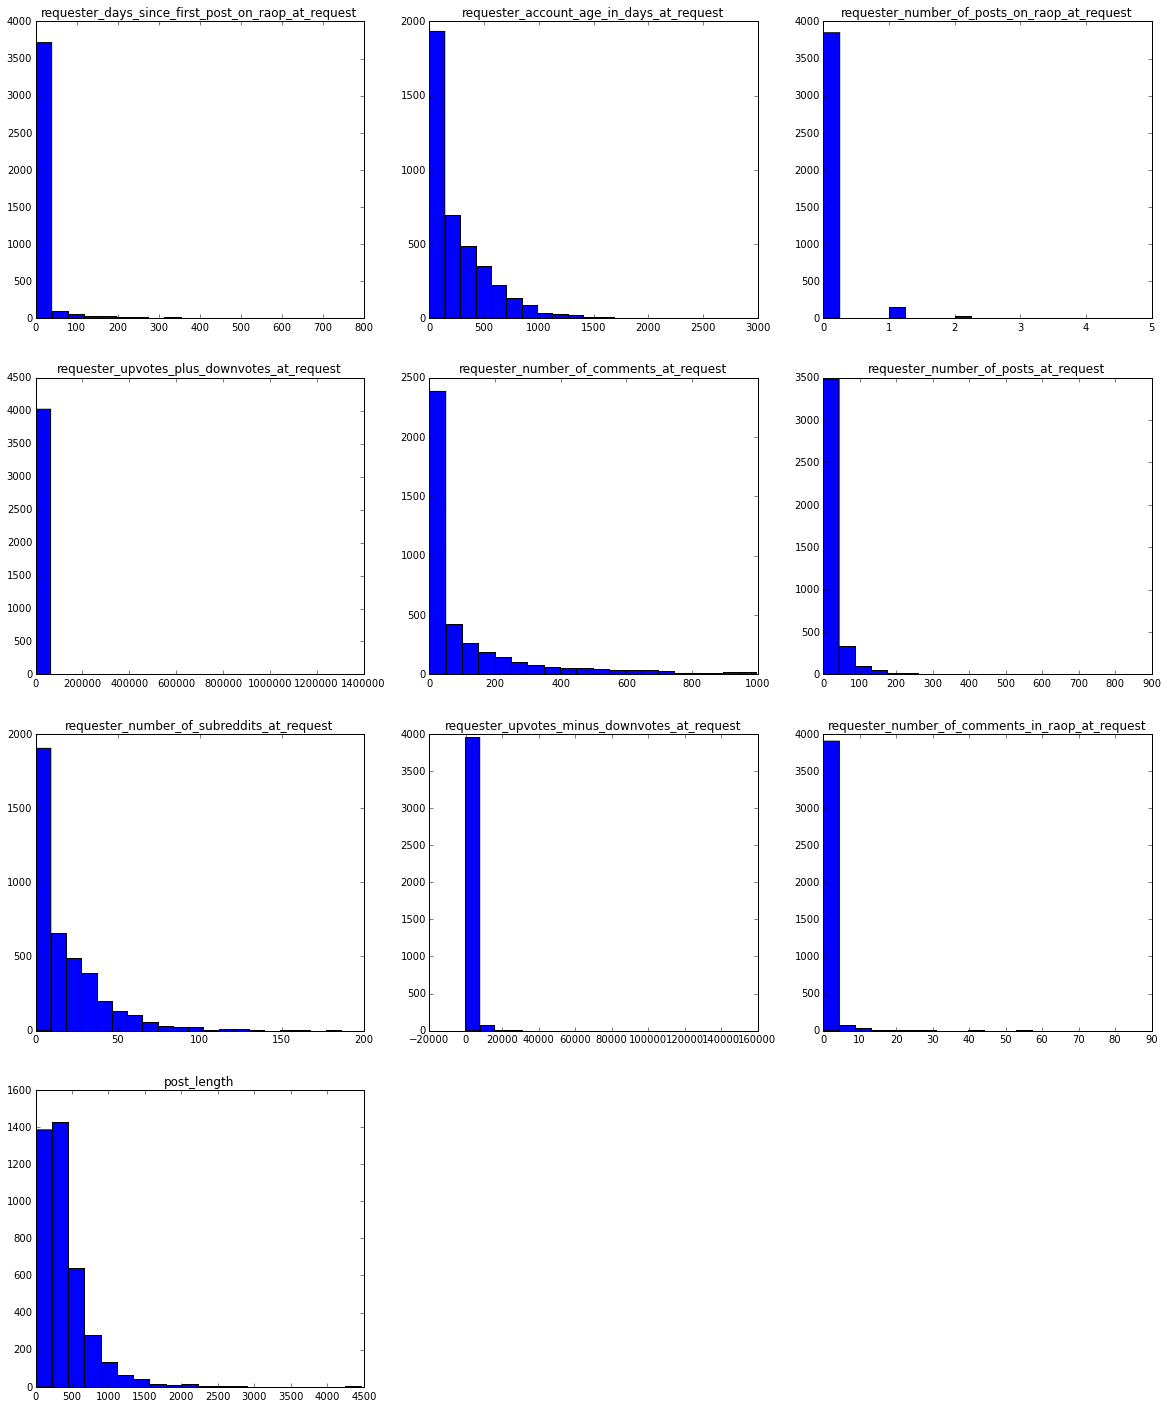

In [7]:
# Plots!
fig = plt.figure(figsize=(20,50))
count = 0
for item, frame in data.iteritems():
    if item in m_features:
        count += 1
        fig.add_subplot(8, 3, count)
        plt.hist(frame, 20)
        plt.title(item)
plt.show()

In [8]:
# shuffle, split 20% to xvalidation, remove labels
np.random.seed(0)
shuffle = np.random.permutation(np.arange(data.shape[0]))

# Pull out text features
train_length = 3230
post_text = list(data['request_text_edit_aware'])
title_text = list(data['request_title'])

train_post_text = post_text[:train_length]
dev_post_text = post_text[train_length:]

train_title_text = title_text[:train_length]
dev_title_text = title_text[train_length:]

# I should have a function for getting columns I want
feat_data = data[m_features]
feat_train_data, feat_train_labels = feat_data.values, labels.values
feat_train_data, feat_train_labels = feat_train_data[shuffle], feat_train_labels[shuffle]

train_data, train_labels = feat_train_data[:train_length], feat_train_labels[:train_length]
dev_data, dev_labels = feat_train_data[train_length:], feat_train_labels[train_length:]

In [9]:
# scale data
scalar = preprocessing.StandardScaler()
scalar.fit(train_data)
scaled_train_data = scalar.transform(train_data)
scaled_dev_data = scalar.transform(dev_data)

In [10]:
# Binarize Data
binarizer = preprocessing.Binarizer().fit(scaled_train_data)
binarized_train_data = binarizer.transform(scaled_train_data)
binarized_dev_data = binarizer.transform(scaled_dev_data)


In [11]:
# KNN
def run_knn(train, dev):
    
    def get_best_k(k_values):
        accuracies = []
        best_k = 1
        best_f1 = 0
        for i in k_values:
            neigh = KNeighborsClassifier(n_neighbors=i)
            neigh.fit(train, train_labels)
            pred = neigh.predict(dev)
            f1_score = metrics.f1_score(pred, dev_labels)
            if f1_score > best_f1:
                best_k = i
                best_f1 = f1_score
        return best_k

    
    def knn(best_k):
        neigh = KNeighborsClassifier(n_neighbors=best_k)
        neigh.fit(train, train_labels)
        pred = neigh.predict(dev)
        print "Accuracy: {}".format(neigh.score(dev, dev_labels))
        print classification_report(pred, dev_labels)

    k_values = np.arange(1,20,1)
    best_k = get_best_k(k_values)
    knn(best_k)
run_knn(scaled_train_data, scaled_dev_data)

Accuracy: 0.703703703704
             precision    recall  f1-score   support

          0       0.85      0.78      0.81       664
          1       0.27      0.37      0.31       146

avg / total       0.74      0.70      0.72       810



In [12]:
def log_reg(train, dev):
    def get_logreg_best_c(param_grid):
        logreg = LogisticRegression()
        logreg = GridSearchCV(logreg, param_grid)
        logreg.fit(train, train_labels)
        for i in logreg.grid_scores_:
            print "{}\n".format(i)
        print("Best C: {}, with and accuracy of: {}".format(logreg.best_params_, logreg.best_score_))
        pred = logreg.predict(dev)
        print classification_report(pred, dev_labels)
    

    def run_logreg():
        logreg = LogisticRegression()
        logreg.fit(train, train_labels)
        print classification_report(logreg.predict(dev), dev_labels)

    
    param_grid = [{'C': np.arange(.01, .1, .01)}]

    get_logreg_best_c(param_grid)    
    run_logreg()
log_reg(scaled_train_data, scaled_dev_data)
print 1 - sum(dev_labels.astype(float))/len(dev_labels.astype(float))
print binarized_train_data

mean: 0.75913, std: 0.00812, params: {'C': 0.01}

mean: 0.75820, std: 0.00786, params: {'C': 0.02}

mean: 0.75820, std: 0.00786, params: {'C': 0.029999999999999999}

mean: 0.75851, std: 0.00902, params: {'C': 0.040000000000000001}

mean: 0.75851, std: 0.00902, params: {'C': 0.050000000000000003}

mean: 0.75820, std: 0.00912, params: {'C': 0.060000000000000005}

mean: 0.75820, std: 0.00912, params: {'C': 0.069999999999999993}

mean: 0.75820, std: 0.00912, params: {'C': 0.080000000000000002}

mean: 0.75851, std: 0.00955, params: {'C': 0.089999999999999997}

Best C: {'C': 0.01}, with and accuracy of: 0.759133126935
             precision    recall  f1-score   support

          0       0.99      0.76      0.86       790
          1       0.06      0.65      0.12        20

avg / total       0.97      0.76      0.84       810

             precision    recall  f1-score   support

          0       0.99      0.76      0.86       787
          1       0.07      0.61      0.12        23

avg 

In [19]:
# Bag of Words model (or tfidf)
def bagofwords():

    def text_features(ngrams=1, tf = False, vocab=None):
        if tf:
            cv = TfidfVectorizer(ngram_range=(1,ngrams), stop_words='english', vocabulary=vocab)
        else:
            cv = CountVectorizer(ngram_range=(1,ngrams), stop_words='english', max_features=1000)
        featvect = cv.fit_transform(train_post_text)
        print "Avg # of nonzero features per entry: %s" % (featvect.nnz / featvect.shape[0])
        print "Fraction of nonzero entries in the matrix: %.2f%%" \
            %(float(featvect.nnz) / (featvect.shape[0]*featvect.shape[1])*100)    
        devect = cv.transform(dev_post_text)
        
        return featvect, devect
    
    def get_mnb(feat_vect, dev_vect):
        mnb = MultinomialNB()
        mnb.fit(feat_vect, train_labels)
        pred = mnb.predict(dev_vect)
        print classification_report(pred, dev_labels)
    
    
    def run_logreg(feat_vect, dev_vect, param_grid):
        logreg = LogisticRegression(penalty='l2')
        logreg = GridSearchCV(logreg, param_grid)
        logreg.fit(feat_vect, train_labels)
        print("Best C: {}, with and accuracy of: {}".format(logreg.best_params_, logreg.best_score_))
        pred = logreg.predict(dev_vect)
        print classification_report(pred, dev_labels)
        
    
    #vocab = ['thank', 'thanks', 'favor', 'return', 'returned', 'grateful']
    feat_vect, dev_vect = text_features(ngrams=1, tf=False)
    # as C goes to 0, accuracy improves...basically guesses 0 for everything
    param_grid = [{'C': np.arange(.1, 1, .1)}]
    run_logreg(feat_vect, dev_vect, param_grid)
    get_mnb(feat_vect, dev_vect)
bagofwords()

Avg # of nonzero features per entry: 22
Fraction of nonzero entries in the matrix: 2.26%
Best C: {'C': 0.10000000000000001}, with and accuracy of: 0.741795665635
             precision    recall  f1-score   support

          0       0.96      0.75      0.84       775
          1       0.05      0.31      0.09        35

avg / total       0.92      0.73      0.81       810

             precision    recall  f1-score   support

          0       0.90      0.75      0.82       726
          1       0.10      0.25      0.15        84

avg / total       0.81      0.70      0.75       810



In [29]:
# Decision Trees? Calculate information gain to see which features are most important?
# install 
def get_decision_tree():
    from sklearn.externals.six import StringIO
    clf = DecisionTreeClassifier(max_depth=30)
    clf = clf.fit(scaled_train_data, train_labels)
    #dot_data = StringIO()
    #export_graphviz(clf, out_file=dot_data) 
    #graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
    #graph.write_pdf("test.pdf")
    pred = clf.predict(scaled_dev_data)
    print clf.score(scaled_dev_data, dev_labels)
    print classification_report(pred, dev_labels)
    
get_decision_tree()
    

0.654320987654
             precision    recall  f1-score   support

          0       0.78      0.76      0.77       622
          1       0.27      0.29      0.28       188

avg / total       0.66      0.65      0.66       810



In [15]:
# Random forest? Boosting? Can you use boosting elsewhere?
import collections
def get_pos_train_text(top_k=10):
    pos_post_text = [train_post_text[i] for i in range(len(train_post_text)) if train_labels[i] == 1]
    neg_post_text = [train_post_text[i] for i in range(len(train_post_text)) if train_labels[i] == 0]
    cv = CountVectorizer(stop_words='english', max_features=top_k)
    cv.fit_transform(pos_post_text)
    pos_words = collections.OrderedDict(sorted(cv.vocabulary_.items()))
    #print pos_words
    
    cv_neg = CountVectorizer(stop_words='english', max_features=top_k)
    cv_neg.fit_transform(neg_post_text)
    neg_words = collections.OrderedDict(sorted(cv_neg.vocabulary_.items()))
    #print neg_words
    
    pos_words = set(pos_words.keys())
    neg_words = set(neg_words.keys())

    neg_dict = [i for i in neg_words if i not in pos_words]
    pos_dict = [i for i in pos_words if i not in neg_words]
    print pos_dict
    
    cv = CountVectorizer(vocabulary=pos_dict)
    cv.fit_transform(train_post_text)
    cv.build_tokenizer()
get_pos_train_text(200)

[u'actually', u'finally', u'redditor', u'www', u'payday', u'sob', u'late', u'probably', u'boyfriend', u'town', u'works', u'hot', u'sick', u'verification', u'picture', u'mother', u'hello']


In [16]:
# day of week?
# time of day? 
# use most common words without stop words -> count how many times each word appears and use top_k
# punctuation, capital letters 
# random forest is typically classifier of choice -> captures non-linear feature interactions
# or use an ensemble of classifiers
# error analysis 

In [63]:
'''
np.random.seed(0)
shuffle = np.random.permutation(np.arange(word_feats.shape[0]))
post_labels = labels.values
word_feats, outcome = word_feats[shuffle], post_labels[shuffle]

train_data, train_labels = word_feats[:3000], outcome[:3000]
dev_data, dev_labels = word_feats[3000:], outcome[3000:]

scalar = preprocessing.MinMaxScaler()
scalar.fit(train_data)
scaled_train_data = scalar.transform(train_data)
scaled_dev_data = scalar.transform(dev_data)
'''

In [79]:
pd.crosstab(np.where(df.job > 0, 1, 0), labels.values).apply(lambda r: r/r.sum(), axis=1)

col_0,0,1
row_0,,
0,0.772784,0.227216
1,0.681818,0.318182


In [80]:
pd.crosstab(np.where(df.money > 0, 1, 0), labels.values).apply(lambda r: r/r.sum(), axis=1)

col_0,0,1
row_0,,
0,0.845679,0.154321
1,0.736439,0.263561


In [81]:
pd.crosstab(np.where(df.student > 0, 1, 0), labels.values).apply(lambda r: r/r.sum(), axis=1)

col_0,0,1
row_0,,
0,0.758887,0.241113
1,0.734161,0.265839


In [82]:
pd.crosstab(np.where(df.family > 0, 1, 0), labels.values).apply(lambda r: r/r.sum(), axis=1)

col_0,0,1
row_0,,
0,0.764651,0.235349
1,0.710526,0.289474
